In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
if (code_show){$('div.input').hide();}
else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

## Fail
- Edges are too fine (detects entire circles)
- Size of image is too big
- Can't read image from file because it is expecting NUMPY arrays
- bottom edges are not thick enough

In [7]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()
d = "../results/"
def plot_times(ax, label, results):
    #colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label, lw=2)
    ax.set_ylabel("Trajectory Length (pico seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
    print "... parsed : " + os.path.basename(results), 
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Node, 1M",   d+"scale-workers-1M-4-71537"))

... parsed : scale-workers-1M-4-71537


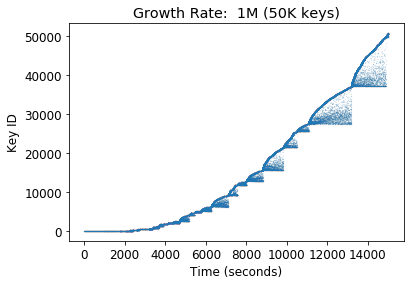

In [92]:
def plot_keytimes(ax, dfs, key_tuple, shift=0):
    d = dfs[key_tuple]['DF_KEY_TIMES']             # get the count df for this run
    ts = int(d['ts'].head(1))                      # first timestep
    d['shift'] = d['ts'] - ts * np.ones(len(d['ts'])) # shift timestamps
    #d = d[d['shift'] > 6000]
    #d = d[d['shift'] < 6500]    

    
    # Create short names for the states
    states = {}
    i = 1
        
    # Iterate over keys and assign state id
    d = d.drop_duplicates()                     # drop duplicates
    stateIDs = []
    for key in d['key']:
        if key not in states:
            states[key] = i
            i += 1            
        stateIDs.append(states[key])
    d['id'] = stateIDs

    ax.scatter(d['shift'], d['id'], s=0.001)
    
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Key ID")
    #ax.set_yticklabels([])
    ax.set_title("Growth Rate: " + key_tuple[0].split(',')[1] + " (" + str(len(states)/1000) + "K keys)")
    return d

fig, ax = plt.subplots(1, 1)
d = plot_keytimes(ax, dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

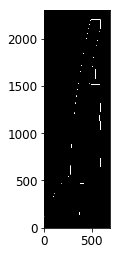

In [90]:
from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt

start = np.min(d['shift'])
h = int(np.max(d['shift']) - start)
w = int(np.max(d['id']))
data = np.ndarray(shape=(w + 200, h + 200), dtype=np.uint8)
#print len(d)
#print np.max(d['id'])
data.fill(0)

i = 0
myx = []
myy = []
for _, e in d.iterrows():
    y = abs(int(e['shift'] - start))
    x = abs(int(e['id']))
    #print "(" + str(x) + "," + str(y) + ") ", 
    i += 1
    myx.append(x)
    myy.append(y)
    for i in range(0, 100):
        for j in range(0, 100):
            data[x + i, y + j] = 255

data = roberts(data)
#for i in range(100, 500):
#    for j in range(100, 500):
#        data[i, j] = 0



fig, ax = plt.subplots(1, 1)#, figsize=(20, 4))
#ax.scatter(myx, myy, s = 0.05)
ax.imshow(data, origin='lower', cmap=plt.cm.gray)